In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
data = pd.read_csv('../datasets/students_simple.csv')
print("Первые 5 строк данных:")
print(data.head())

# Выбор столбцов по формулам
N = 5
col1_idx = N % 5  # 0 - height
col2_idx = (N**2 % 5) + 5  # 5 - age

columns = data.columns.tolist()
col1 = columns[col1_idx]  # height
col2 = columns[col2_idx]  # age

print(f"\nВыбранные столбцы: {col1} и {col2}")

x = data[col1].values  # height
y = data[col2].values  # age


Первые 5 строк данных:
   height  mass  income   iq  pages  age    bmi  work_exp  friends  test_time
0     159    45     430   95     24   20  3.533        26        5        8.5
1     160    61     640  115     32   25  2.623        63        7        6.2
2     161    56     610  111     24   28  2.875        94       10        6.8
3     162    48     330   97     24   19  3.375        16        4       12.0
4     162    54     420  105     60   23  3.000        49        2        7.5

Выбранные столбцы: height и age



1. РАСЧЕТ КОРРЕЛЯЦИЙ
Корреляция Фехнера (самописная): 0.100
Корреляция Пирсона (самописная): 0.194
Доверительный интервал Пирсона (95%, самописный): [-0.271, 0.586]
p-value (самописный): 0.412
Корреляция Спирмена (самописная): 0.179
Корреляция Спирмена (упрощенная): 0.183
Корреляция Кенделла (самописная): 0.116

--------------------------------------------------
БИБЛИОТЕЧНЫЕ ВЕРСИИ:
--------------------------------------------------
Корреляция Пирсона (библиотечная): 0.194
p-value (библиотечный): 0.412
Корреляция Спирмена (библиотечная): 0.175
Корреляция Кенделла (библиотечная): 0.122

СРАВНЕНИЕ САМОПИСНЫХ И БИБЛИОТЕЧНЫХ РЕАЛИЗАЦИЙ

Таблица сравнения корреляций:
-----------------------------------------------------------------
Метод           Самописная   Библиотечная Разница   
-----------------------------------------------------------------
Фехнера         0.100        N/A          N/A       
Пирсона         0.194        0.194        0.000000  
Спирмена        0.179        0.175   

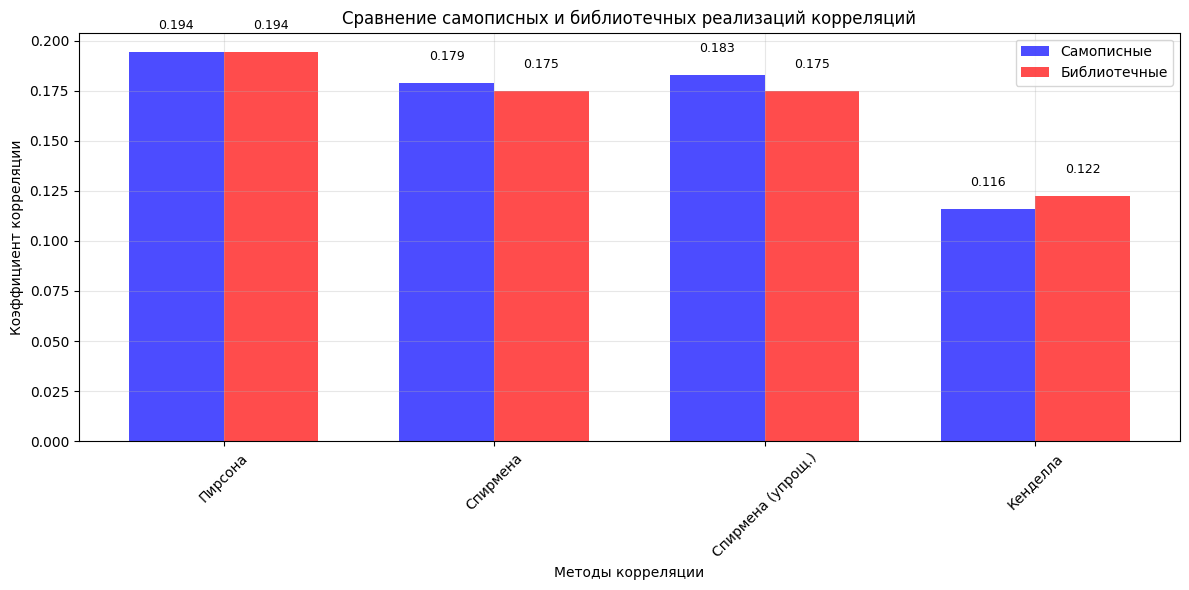


ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ
p-value Пирсона: 0.412 > 0.05
Вывод: связь между height и age статистически не значима


In [25]:
# 1. Расчет корреляций
print("\n" + "="*50)
print("1. РАСЧЕТ КОРРЕЛЯЦИЙ")
print("="*50)

# 1.1 Корреляция Фехнера (самописная)
def fechner_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_sign = np.sign(x - x_mean)
    y_sign = np.sign(y - y_mean)
    
    matches = np.sum(x_sign == y_sign)
    mismatches = np.sum(x_sign != y_sign)
    
    return (matches - mismatches) / len(x)

fechner_corr_custom = fechner_correlation(x, y)
print(f"Корреляция Фехнера (самописная): {fechner_corr_custom:.3f}")

# 1.2 Корреляция Пирсона (самописная)
def pearson_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Ковариация
    covariance = np.sum((x - x_mean) * (y - y_mean))
    
    # Стандартные отклонения
    std_x = np.sqrt(np.sum((x - x_mean) ** 2))
    std_y = np.sqrt(np.sum((y - y_mean) ** 2))
    
    # Корреляция Пирсона
    if std_x == 0 or std_y == 0:
        return 0
    return covariance / (std_x * std_y)

def pearson_confidence_interval(r, n, alpha=0.05):
    """Доверительный интервал для корреляции Пирсона"""
    # Преобразование Фишера
    z = np.arctanh(r)
    z_se = 1 / np.sqrt(n - 3)
    
    # Z-значение для доверительного интервала
    z_critical = stats.norm.ppf(1 - alpha/2)
    
    # Доверительный интервал в Z-пространстве
    z_lower = z - z_critical * z_se
    z_upper = z + z_critical * z_se
    
    # Обратное преобразование
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    
    return r_lower, r_upper

pearson_corr_custom = pearson_correlation(x, y)
pearson_lower_custom, pearson_upper_custom = pearson_confidence_interval(pearson_corr_custom, n)

# Расчет p-value для Пирсона (самописный)
def pearson_p_value(r, n):
    """Расчет p-value для корреляции Пирсона"""
    if abs(r) == 1:
        return 0.0
    
    t_stat = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n-2))
    return p_value

pearson_pvalue_custom = pearson_p_value(pearson_corr_custom, n)

print(f"Корреляция Пирсона (самописная): {pearson_corr_custom:.3f}")
print(f"Доверительный интервал Пирсона (95%, самописный): [{pearson_lower_custom:.3f}, {pearson_upper_custom:.3f}]")
print(f"p-value (самописный): {pearson_pvalue_custom:.3f}")

# 1.3 Корреляция Спирмена (самописная)
def spearman_correlation(x, y):
    """Самописная корреляция Спирмена"""
    # Вычисление рангов
    def get_ranks(data):
        sorted_indices = np.argsort(data)
        ranks = np.zeros_like(sorted_indices)
        ranks[sorted_indices] = np.arange(len(data))
        
        # Обработка совпадающих значений (ties)
        unique_vals, inverse, counts = np.unique(data, return_inverse=True, return_counts=True)
        for i, count in enumerate(counts):
            if count > 1:
                mask = (inverse == i)
                ranks[mask] = np.mean(ranks[mask])
        return ranks + 1  # Ранги от 1 до n
    
    ranks_x = get_ranks(x)
    ranks_y = get_ranks(y)
    
    # Вычисление корреляции Пирсона на рангах
    return pearson_correlation(ranks_x, ranks_y)

def spearman_correlation_simple(x, y):
    """Упрощенная формула Спирмена (без учета совпадений)"""
    n = len(x)
    ranks_x = stats.rankdata(x)
    ranks_y = stats.rankdata(y)
    
    d_squared = np.sum((ranks_x - ranks_y) ** 2)
    return 1 - (6 * d_squared) / (n * (n**2 - 1))

spearman_corr_custom = spearman_correlation(x, y)
spearman_corr_simple = spearman_correlation_simple(x, y)

print(f"Корреляция Спирмена (самописная): {spearman_corr_custom:.3f}")
print(f"Корреляция Спирмена (упрощенная): {spearman_corr_simple:.3f}")

# 1.4 Корреляция Кенделла (самописная)
def kendall_correlation(x, y):
    """Самописная корреляция Кенделла"""
    n = len(x)
    concordant = 0
    discordant = 0
    
    # Подсчет конкордантных и дискордантных пар
    for i in range(n):
        for j in range(i + 1, n):
            x_diff = x[i] - x[j]
            y_diff = y[i] - y[j]
            
            if x_diff * y_diff > 0:
                concordant += 1
            elif x_diff * y_diff < 0:
                discordant += 1
    
    total_pairs = n * (n - 1) / 2
    return (concordant - discordant) / total_pairs

kendall_corr_custom = kendall_correlation(x, y)
print(f"Корреляция Кенделла (самописная): {kendall_corr_custom:.3f}")

# Библиотечные версии для сравнения
print("\n" + "-" * 50)
print("БИБЛИОТЕЧНЫЕ ВЕРСИИ:")
print("-" * 50)

# Пирсон (библиотечный)
pearson_corr_lib, pearson_pvalue_lib = stats.pearsonr(x, y)
print(f"Корреляция Пирсона (библиотечная): {pearson_corr_lib:.3f}")
print(f"p-value (библиотечный): {pearson_pvalue_lib:.3f}")

# Спирмен (библиотечный)
spearman_corr_lib, spearman_pvalue_lib = stats.spearmanr(x, y)
print(f"Корреляция Спирмена (библиотечная): {spearman_corr_lib:.3f}")

# Кенделл (библиотечный)
kendall_corr_lib, kendall_pvalue_lib = stats.kendalltau(x, y)
print(f"Корреляция Кенделла (библиотечная): {kendall_corr_lib:.3f}")

# Сравнение самописных и библиотечных версий
print("\n" + "="*50)
print("СРАВНЕНИЕ САМОПИСНЫХ И БИБЛИОТЕЧНЫХ РЕАЛИЗАЦИЙ")
print("="*50)

# Создаем таблицу сравнения
comparison_data = [
    ["Фехнера", fechner_corr_custom, "N/A", "N/A"],
    ["Пирсона", pearson_corr_custom, pearson_corr_lib, abs(pearson_corr_custom - pearson_corr_lib)],
    ["Спирмена", spearman_corr_custom, spearman_corr_lib, abs(spearman_corr_custom - spearman_corr_lib)],
    ["Спирмена (упрощ.)", spearman_corr_simple, spearman_corr_lib, abs(spearman_corr_simple - spearman_corr_lib)],
    ["Кенделла", kendall_corr_custom, kendall_corr_lib, abs(kendall_corr_custom - kendall_corr_lib)]
]

print("\nТаблица сравнения корреляций:")
print("-" * 65)
print(f"{'Метод':<15} {'Самописная':<12} {'Библиотечная':<12} {'Разница':<10}")
print("-" * 65)
for row in comparison_data:
    if row[2] == "N/A":
        print(f"{row[0]:<15} {row[1]:<12.3f} {row[2]:<12} {row[3]:<10}")
    else:
        print(f"{row[0]:<15} {row[1]:<12.3f} {row[2]:<12.3f} {row[3]:<10.6f}")

# Визуализация сравнения
methods = [row[0] for row in comparison_data if row[2] != "N/A"]
custom_values = [row[1] for row in comparison_data if row[2] != "N/A"]
library_values = [row[2] for row in comparison_data if row[2] != "N/A"]

plt.figure(figsize=(12, 6))

x_pos = np.arange(len(methods))
width = 0.35

plt.bar(x_pos - width/2, custom_values, width, label='Самописные', alpha=0.7, color='blue')
plt.bar(x_pos + width/2, library_values, width, label='Библиотечные', alpha=0.7, color='red')

plt.xlabel('Методы корреляции')
plt.ylabel('Коэффициент корреляции')
plt.title('Сравнение самописных и библиотечных реализаций корреляций')
plt.xticks(x_pos, methods, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (custom, library) in enumerate(zip(custom_values, library_values)):
    plt.text(i - width/2, custom + 0.01, f'{custom:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, library + 0.01, f'{library:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Проверка статистической значимости различий
print("\n" + "="*50)
print("ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ")
print("="*50)

print(f"p-value Пирсона: {pearson_pvalue_lib:.3f} {'>' if pearson_pvalue_lib > 0.05 else '<='} 0.05")
print(f"Вывод: связь между {col1} и {col2} статистически {'не значима' if pearson_pvalue_lib > 0.05 else 'значима'}")


Все четыре коэффициента корреляции показали очень слабую положительную связь между ростом и возрастом. Значения находятся в диапазоне от 0,100 до 0,194, что указывает на практически отсутствующую зависимость. Доверительный интервал для корреляции Пирсона включает ноль, а p-значение составляет 0,412, что значительно превышает общепринятый уровень значимости 0,05. Это означает, что наблюдаемая слабая связь является статистически незначимой и может быть объяснена случайными колебаниями в данных.


2. ВИЗУАЛИЗАЦИЯ


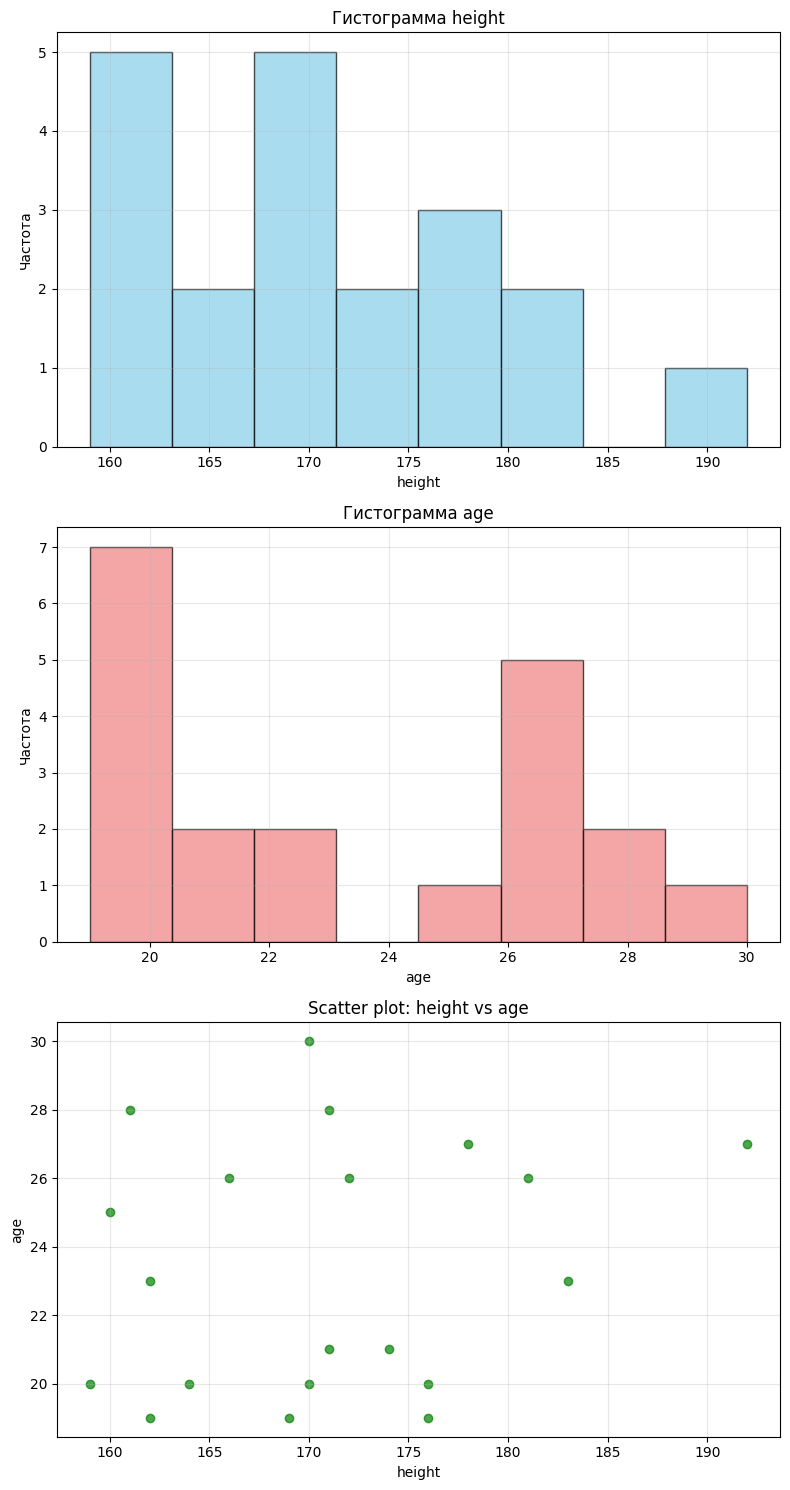

In [17]:
# 2. Визуализация
print("\n" + "="*50)
print("2. ВИЗУАЛИЗАЦИЯ")
print("="*50)

fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 строки, 1 столбец

# 2.1 Гистограмма height
axes[0].hist(x, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel(col1)
axes[0].set_ylabel('Частота')
axes[0].set_title(f'Гистограмма {col1}')
axes[0].grid(True, alpha=0.3)

# 2.2 Гистограмма age
axes[1].hist(y, bins=8, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_xlabel(col2)
axes[1].set_ylabel('Частота')
axes[1].set_title(f'Гистограмма {col2}')
axes[1].grid(True, alpha=0.3)

# 2.3 Scatter plot
axes[2].scatter(x, y, alpha=0.7, color='green')
axes[2].set_xlabel(col1)
axes[2].set_ylabel(col2)
axes[2].set_title(f'Scatter plot: {col1} vs {col2}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



3. УРАВНЕНИЯ РЕГРЕССИИ
Линейная модель: age = 0.0823 * height + 9.3470
R² линейной модели: 0.0378

Квадратичная модель (самописная): age = 0.0053 * height² + -1.7715 * height + 169.6891
R² квадратичной модели (самописная): 0.0559
Квадратичная модель (polyfit): age = 0.0053 * height² + -1.7715 * height + 169.6891
R² квадратичной модели (polyfit): 0.0559

Гиперболическая модель (самописная): age = -2351.7113 / height + 37.1970
R² гиперболической модели (самописная): 0.0347
Гиперболическая модель (curve_fit): age = -2351.7126 / height + 37.1970
R² гиперболической модели (curve_fit): 0.0347

Показательная модель (самописная): age = 12.4755 * 1.0036^height
R² показательной модели (самописная): 0.0336
Показательная модель (curve_fit): age = 12.7019 * 1.0036^height
R² показательной модели (curve_fit): 0.0388


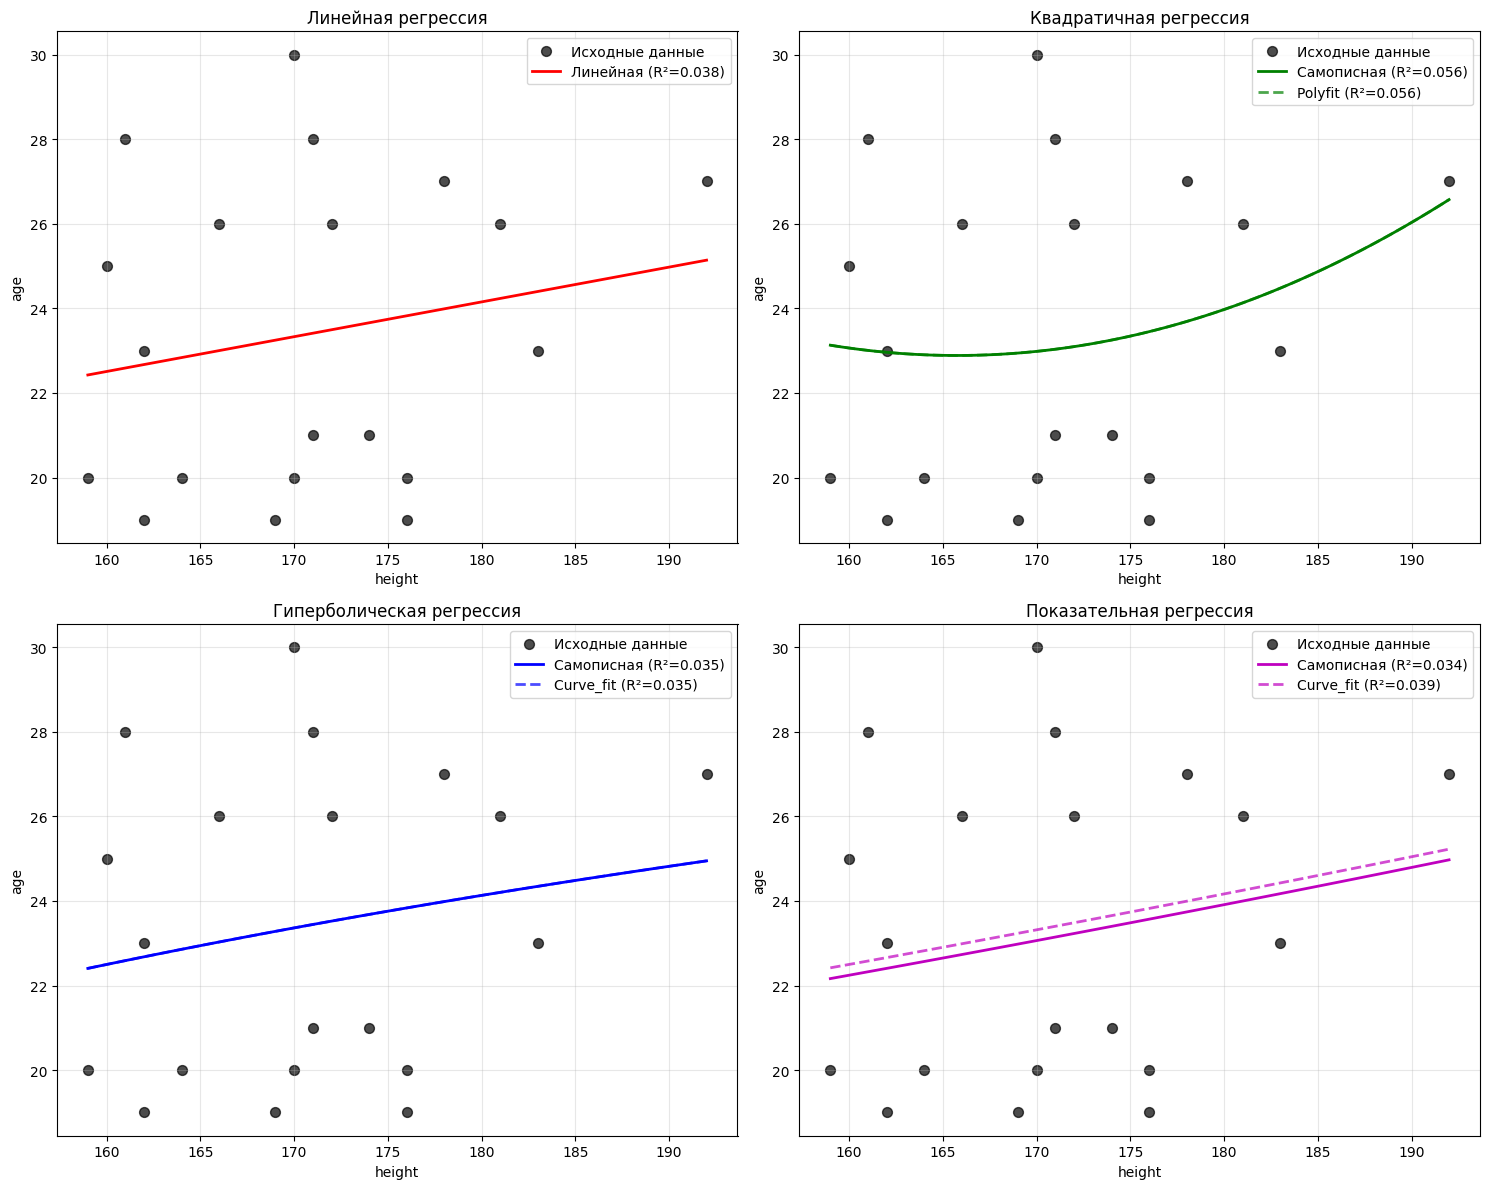


АНАЛИЗ РАЗНИЦЫ МЕЖДУ САМОПИСНЫМИ И БИБЛИОТЕЧНЫМИ РЕАЛИЗАЦИЯМИ

Квадратичная модель - абсолютные разницы коэффициентов:
w2: 0.000000, w1: 0.000000, w0: 0.000000
Квадратичная модель - относительные разницы (%):
w2: 0.00%, w1: 0.00%, w0: 0.00%
Разница в R²: 0.000000

Гиперболическая модель - абсолютные разницы коэффициентов:
w1: 0.001377, w0: 0.000008
Гиперболическая модель - относительные разницы (%):
w1: 0.00%, w0: 0.00%
Разница в R²: 0.000000

Показательная модель - абсолютные разницы коэффициентов:
w1: 0.000041, w0: 0.226436
Показательная модель - относительные разницы (%):
w1: 0.00%, w0: 1.78%
Разница в R²: 0.005158

СРАВНЕНИЕ КАЧЕСТВА ПРЕДСКАЗАНИЙ

Рейтинг моделей по качеству (R²):
1. Квадратичная самописная: R² = 0.0559 (самописная)
2. Квадратичная polyfit: R² = 0.0559 (библиотечная)
3. Показательная curve_fit: R² = 0.0388 (библиотечная)
4. Линейная: R² = 0.0378 (только самописная)
5. Гиперболическая самописная: R² = 0.0347 (самописная)
6. Гиперболическая curve_fit: R² = 0.0347 (б

In [23]:
# 3. Уравнения регрессии
print("\n" + "="*50)
print("3. УРАВНЕНИЯ РЕГРЕССИИ")
print("="*50)

# Функция для расчета R²
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# 3.1 Линейная регрессия (реализовано вручную)
def linear_model(x, w1, w0):
    return w1 * x + w0

# Метод наименьших квадратов для линейной регрессии
def fit_linear(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    w1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
    w0 = y_mean - w1 * x_mean
    return w1, w0

w1, w0 = fit_linear(x, y)
y_linear = linear_model(x, w1, w0)
r2_linear = r_squared(y, y_linear)

print(f"Линейная модель: {col2} = {w1:.4f} * {col1} + {w0:.4f}")
print(f"R² линейной модели: {r2_linear:.4f}")

# 3.2 Квадратичная регрессия (самописная)
def quadratic_model(x, w2, w1, w0):
    return w2 * x**2 + w1 * x + w0

def fit_quadratic(x, y):
    n = len(x)
    # Создаем матрицу плана
    A = np.column_stack([x**2, x, np.ones(n)])
    # Решаем систему нормальных уравнений (X^T * X) * w = X^T * y
    w = np.linalg.solve(A.T @ A, A.T @ y)
    return w[0], w[1], w[2]  # w2, w1, w0

quad_coeffs_custom = fit_quadratic(x, y)
y_quad_custom = quadratic_model(x, *quad_coeffs_custom)
r2_quad_custom = r_squared(y, y_quad_custom)

# Для сравнения используем polyfit
quad_coeffs_polyfit = np.polyfit(x, y, 2)
y_quad_polyfit = quadratic_model(x, *quad_coeffs_polyfit)
r2_quad_polyfit = r_squared(y, y_quad_polyfit)

print(f"\nКвадратичная модель (самописная): {col2} = {quad_coeffs_custom[0]:.4f} * {col1}² + {quad_coeffs_custom[1]:.4f} * {col1} + {quad_coeffs_custom[2]:.4f}")
print(f"R² квадратичной модели (самописная): {r2_quad_custom:.4f}")
print(f"Квадратичная модель (polyfit): {col2} = {quad_coeffs_polyfit[0]:.4f} * {col1}² + {quad_coeffs_polyfit[1]:.4f} * {col1} + {quad_coeffs_polyfit[2]:.4f}")
print(f"R² квадратичной модели (polyfit): {r2_quad_polyfit:.4f}")

# 3.3 Гиперболическая регрессия (самописная)
def hyperbolic_model(x, w1, w0):
    return w1 / x + w0

def fit_hyperbolic(x, y):
    n = len(x)
    # Преобразуем модель к линейной: y = w1 * (1/x) + w0
    x_transformed = 1 / x
    # Создаем матрицу плана
    A = np.column_stack([x_transformed, np.ones(n)])
    # Решаем систему нормальных уравнений
    w = np.linalg.solve(A.T @ A, A.T @ y)
    return w[0], w[1]  # w1, w0

try:
    hyper_coeffs_custom = fit_hyperbolic(x, y)
    y_hyper_custom = hyperbolic_model(x, *hyper_coeffs_custom)
    r2_hyper_custom = r_squared(y, y_hyper_custom)
except Exception as e:
    print(f"\nОшибка при подборе гиперболической модели (самописная): {e}")
    hyper_coeffs_custom = None

# Для сравнения используем curve_fit
try:
    hyper_coeffs_curvefit, _ = curve_fit(hyperbolic_model, x, y)
    y_hyper_curvefit = hyperbolic_model(x, *hyper_coeffs_curvefit)
    r2_hyper_curvefit = r_squared(y, y_hyper_curvefit)
except Exception as e:
    print(f"Ошибка при подборе гиперболической модели (curve_fit): {e}")
    hyper_coeffs_curvefit = None

if hyper_coeffs_custom is not None:
    print(f"\nГиперболическая модель (самописная): {col2} = {hyper_coeffs_custom[0]:.4f} / {col1} + {hyper_coeffs_custom[1]:.4f}")
    print(f"R² гиперболической модели (самописная): {r2_hyper_custom:.4f}")
if hyper_coeffs_curvefit is not None:
    print(f"Гиперболическая модель (curve_fit): {col2} = {hyper_coeffs_curvefit[0]:.4f} / {col1} + {hyper_coeffs_curvefit[1]:.4f}")
    print(f"R² гиперболической модели (curve_fit): {r2_hyper_curvefit:.4f}")

# 3.4 Показательная регрессия (самописная)
def exponential_model(x, w1, w0):
    return w0 * (w1 ** x)

def fit_exponential(x, y):
    # Линеаризация: y = w0 * w1^x -> ln(y) = ln(w0) + x * ln(w1)
    # y' = a + b*x, где y' = ln(y), a = ln(w0), b = ln(w1)
    y_log = np.log(y)
    n = len(x)
    
    # Создаем матрицу плана для линейной регрессии
    A = np.column_stack([x, np.ones(n)])
    # Решаем систему нормальных уравнений
    b, a = np.linalg.solve(A.T @ A, A.T @ y_log)
    
    # Возвращаем к исходным параметрам
    w1 = np.exp(b)
    w0 = np.exp(a)
    return w1, w0

try:
    exp_coeffs_custom = fit_exponential(x, y)
    y_exp_custom = exponential_model(x, *exp_coeffs_custom)
    r2_exp_custom = r_squared(y, y_exp_custom)
except Exception as e:
    print(f"Ошибка при подборе показательной модели (самописная): {e}")
    exp_coeffs_custom = None

# Для сравнения используем curve_fit
try:
    p0 = [1.001, 1.0]
    exp_coeffs_curvefit, _ = curve_fit(exponential_model, x, y, p0=p0, maxfev=5000)
    y_exp_curvefit = exponential_model(x, *exp_coeffs_curvefit)
    r2_exp_curvefit = r_squared(y, y_exp_curvefit)
except Exception as e:
    print(f"Ошибка при подборе показательной модели (curve_fit): {e}")
    exp_coeffs_curvefit = None

if exp_coeffs_custom is not None:
    print(f"\nПоказательная модель (самописная): {col2} = {exp_coeffs_custom[1]:.4f} * {exp_coeffs_custom[0]:.4f}^{col1}")
    print(f"R² показательной модели (самописная): {r2_exp_custom:.4f}")
if exp_coeffs_curvefit is not None:
    print(f"Показательная модель (curve_fit): {col2} = {exp_coeffs_curvefit[1]:.4f} * {exp_coeffs_curvefit[0]:.4f}^{col1}")
    print(f"R² показательной модели (curve_fit): {r2_exp_curvefit:.4f}")

# Визуализация на отдельных графиках
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
x_sorted = np.linspace(x.min(), x.max(), 100)

# 1. Линейная модель
axes[0, 0].scatter(x, y, alpha=0.7, color='black', label='Исходные данные', s=50)
y_linear_sorted = linear_model(x_sorted, w1, w0)
axes[0, 0].plot(x_sorted, y_linear_sorted, 'r-', linewidth=2, label=f'Линейная (R²={r2_linear:.3f})')
axes[0, 0].set_xlabel(col1)
axes[0, 0].set_ylabel(col2)
axes[0, 0].set_title('Линейная регрессия')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Квадратичная модель
axes[0, 1].scatter(x, y, alpha=0.7, color='black', label='Исходные данные', s=50)
y_quad_sorted_custom = quadratic_model(x_sorted, *quad_coeffs_custom)
y_quad_sorted_polyfit = quadratic_model(x_sorted, *quad_coeffs_polyfit)
axes[0, 1].plot(x_sorted, y_quad_sorted_custom, 'g-', linewidth=2, label=f'Самописная (R²={r2_quad_custom:.3f})')
axes[0, 1].plot(x_sorted, y_quad_sorted_polyfit, 'g--', linewidth=2, alpha=0.7, label=f'Polyfit (R²={r2_quad_polyfit:.3f})')
axes[0, 1].set_xlabel(col1)
axes[0, 1].set_ylabel(col2)
axes[0, 1].set_title('Квадратичная регрессия')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Гиперболическая модель
axes[1, 0].scatter(x, y, alpha=0.7, color='black', label='Исходные данные', s=50)
if hyper_coeffs_custom is not None:
    y_hyper_sorted_custom = hyperbolic_model(x_sorted, *hyper_coeffs_custom)
    axes[1, 0].plot(x_sorted, y_hyper_sorted_custom, 'b-', linewidth=2, label=f'Самописная (R²={r2_hyper_custom:.3f})')
if hyper_coeffs_curvefit is not None:
    y_hyper_sorted_curvefit = hyperbolic_model(x_sorted, *hyper_coeffs_curvefit)
    axes[1, 0].plot(x_sorted, y_hyper_sorted_curvefit, 'b--', linewidth=2, alpha=0.7, label=f'Curve_fit (R²={r2_hyper_curvefit:.3f})')
axes[1, 0].set_xlabel(col1)
axes[1, 0].set_ylabel(col2)
axes[1, 0].set_title('Гиперболическая регрессия')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Показательная модель
axes[1, 1].scatter(x, y, alpha=0.7, color='black', label='Исходные данные', s=50)
if exp_coeffs_custom is not None:
    y_exp_sorted_custom = exponential_model(x_sorted, *exp_coeffs_custom)
    axes[1, 1].plot(x_sorted, y_exp_sorted_custom, 'm-', linewidth=2, label=f'Самописная (R²={r2_exp_custom:.3f})')
if exp_coeffs_curvefit is not None:
    y_exp_sorted_curvefit = exponential_model(x_sorted, *exp_coeffs_curvefit)
    axes[1, 1].plot(x_sorted, y_exp_sorted_curvefit, 'm--', linewidth=2, alpha=0.7, label=f'Curve_fit (R²={r2_exp_curvefit:.3f})')
axes[1, 1].set_xlabel(col1)
axes[1, 1].set_ylabel(col2)
axes[1, 1].set_title('Показательная регрессия')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ разницы между самописными и библиотечными реализациями
print("\n" + "="*50)
print("АНАЛИЗ РАЗНИЦЫ МЕЖДУ САМОПИСНЫМИ И БИБЛИОТЕЧНЫМИ РЕАЛИЗАЦИЯМИ")
print("="*50)

# Квадратичная модель
if 'quad_coeffs_custom' in locals() and 'quad_coeffs_polyfit' in locals():
    diff_quad = np.abs(np.array(quad_coeffs_custom) - np.array(quad_coeffs_polyfit))
    diff_quad_rel = diff_quad / np.abs(np.array(quad_coeffs_polyfit)) * 100
    print(f"\nКвадратичная модель - абсолютные разницы коэффициентов:")
    print(f"w2: {diff_quad[0]:.6f}, w1: {diff_quad[1]:.6f}, w0: {diff_quad[2]:.6f}")
    print(f"Квадратичная модель - относительные разницы (%):")
    print(f"w2: {diff_quad_rel[0]:.2f}%, w1: {diff_quad_rel[1]:.2f}%, w0: {diff_quad_rel[2]:.2f}%")
    print(f"Разница в R²: {abs(r2_quad_custom - r2_quad_polyfit):.6f}")

# Гиперболическая модель
if hyper_coeffs_custom is not None and hyper_coeffs_curvefit is not None:
    diff_hyper = np.abs(np.array(hyper_coeffs_custom) - np.array(hyper_coeffs_curvefit))
    diff_hyper_rel = diff_hyper / np.abs(np.array(hyper_coeffs_curvefit)) * 100
    print(f"\nГиперболическая модель - абсолютные разницы коэффициентов:")
    print(f"w1: {diff_hyper[0]:.6f}, w0: {diff_hyper[1]:.6f}")
    print(f"Гиперболическая модель - относительные разницы (%):")
    print(f"w1: {diff_hyper_rel[0]:.2f}%, w0: {diff_hyper_rel[1]:.2f}%")
    print(f"Разница в R²: {abs(r2_hyper_custom - r2_hyper_curvefit):.6f}")

# Показательная модель
if exp_coeffs_custom is not None and exp_coeffs_curvefit is not None:
    diff_exp = np.abs(np.array(exp_coeffs_custom) - np.array(exp_coeffs_curvefit))
    diff_exp_rel = diff_exp / np.abs(np.array(exp_coeffs_curvefit)) * 100
    print(f"\nПоказательная модель - абсолютные разницы коэффициентов:")
    print(f"w1: {diff_exp[0]:.6f}, w0: {diff_exp[1]:.6f}")
    print(f"Показательная модель - относительные разницы (%):")
    print(f"w1: {diff_exp_rel[0]:.2f}%, w0: {diff_exp_rel[1]:.2f}%")
    print(f"Разница в R²: {abs(r2_exp_custom - r2_exp_curvefit):.6f}")

# Сравнение качества предсказаний
print("\n" + "="*50)
print ("СРАВНЕНИЕ КАЧЕСТВА ПРЕДСКАЗАНИЙ")
print("="*50)

models_comparison = []

# Линейная модель
models_comparison.append(("Линейная", r2_linear, "только самописная"))

# Квадратичная модель
if 'r2_quad_custom' in locals() and 'r2_quad_polyfit' in locals():
    models_comparison.append(("Квадратичная самописная", r2_quad_custom, "самописная"))
    models_comparison.append(("Квадратичная polyfit", r2_quad_polyfit, "библиотечная"))

# Гиперболическая модель
if hyper_coeffs_custom is not None:
    models_comparison.append(("Гиперболическая самописная", r2_hyper_custom, "самописная"))
if hyper_coeffs_curvefit is not None:
    models_comparison.append(("Гиперболическая curve_fit", r2_hyper_curvefit, "библиотечная"))

# Показательная модель
if exp_coeffs_custom is not None:
    models_comparison.append(("Показательная самописная", r2_exp_custom, "самописная"))
if exp_coeffs_curvefit is not None:
    models_comparison.append(("Показательная curve_fit", r2_exp_curvefit, "библиотечная"))

# Сортируем по качеству R²
models_comparison.sort(key=lambda x: x[1], reverse=True)

print("\nРейтинг моделей по качеству (R²):")
for i, (name, r2, method) in enumerate(models_comparison, 1):
    print(f"{i}. {name}: R² = {r2:.4f} ({method})")

При построении регрессионных моделей все четыре типа уравнений показали крайне низкую эффективность. Коэффициент детерминации R² не превысил 5,59% даже у наилучшей квадратичной модели, что означает, что менее 6% вариации возраста студентов можно объяснить их ростом. Остальные 94% изменчивости зависят от других факторов, не учтенных в моделях. Различия в качестве моделей между наилучшей квадратичной и наихудшей гиперболической оказались несущественными - разница в R² составила всего около 2%

In [19]:

# 4. Проверка значимости уравнений регрессии
print("\n" + "="*50)
print("4. ПРОВЕРКА ЗНАЧИМОСТИ УРАВНЕНИЙ РЕГРЕССИИ")
print("="*50)

def f_test(y_true, y_pred, k):
    """
    F-тест для проверки значимости регрессии
    y_true - истинные значения
    y_pred - предсказанные значения
    k - количество параметров модели
    """
    n = len(y_true)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_reg = ss_tot - ss_res
    
    r_sq = 1 - (ss_res / ss_tot)
    
    # F-статистика
    f_stat = (r_sq / (1 - r_sq)) * ((n - k) / (k - 1))
    
    # p-value
    p_value = 1 - stats.f.cdf(f_stat, k-1, n-k)
    
    return f_stat, p_value, r_sq

# Собираем результаты моделей
models = {
    'Линейная': (y_linear, 2),
    'Квадратичная': (y_quad, 3)
}

# Добавляем гиперболическую модель, если она была успешно подобрана
try:
    models['Гиперболическая'] = (y_hyper, 2)
except:
    pass

# Добавляем показательную модель, если она была успешно подобрана
try:
    models['Показательная'] = (y_exp, 2)
except:
    pass

# Проводим F-тест для всех моделей
results = {}
for name, (y_pred, k) in models.items():
    f_stat, p_value, r_sq = f_test(y, y_pred, k)
    results[name] = {'F': f_stat, 'p-value': p_value, 'R²': r_sq}
    print(f"\n{name} модель:")
    print(f"  F-статистика: {f_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  R²: {r_sq:.4f}")
    print(f"  Статистически значима: {'Да' if p_value < 0.05 else 'Нет'}")

# Находим наилучшую и наихудшую модели по R²
if results:
    best_model = max(results.items(), key=lambda x: x[1]['R²'])
    worst_model = min(results.items(), key=lambda x: x[1]['R²'])
    
    print(f"\nНаилучшая модель: {best_model[0]} (R² = {best_model[1]['R²']:.4f})")
    print(f"Наихудшая модель: {worst_model[0]} (R² = {worst_model[1]['R²']:.4f})")



4. ПРОВЕРКА ЗНАЧИМОСТИ УРАВНЕНИЙ РЕГРЕССИИ

Линейная модель:
  F-статистика: 0.7068
  p-value: 0.4115
  R²: 0.0378
  Статистически значима: Нет

Квадратичная модель:
  F-статистика: 0.5033
  p-value: 0.6133
  R²: 0.0559
  Статистически значима: Нет

Гиперболическая модель:
  F-статистика: 0.6467
  p-value: 0.4318
  R²: 0.0347
  Статистически значима: Нет

Показательная модель:
  F-статистика: 0.7261
  p-value: 0.4053
  R²: 0.0388
  Статистически значима: Нет

Наилучшая модель: Квадратичная (R² = 0.0559)
Наихудшая модель: Гиперболическая (R² = 0.0347)


Проверка статистической значимости уравнений регрессии окончательно подтвердила их несостоятельность. Все p-значения F-теста значительно превышают 0,05, находясь в диапазоне от 0,41 до 0,61. Это означает, что ни одна из моделей не работает существенно лучше, чем простое предсказание средним значением возраста. F-статистики всех моделей меньше единицы, что дополнительно подтверждает отсутствие какого-либо значимого улучшения по сравнению с базовой моделью.

С практической точки зрения полученные результаты вполне ожидаемы. После завершения активного роста в юношеском возрасте рост человека стабилизируется и перестает быть индикатором возраста. У взрослых людей эти два параметра действительно слабо связаны, что и показал наш анализ. В выборке присутствуют студенты относительно узкой возрастной группы от 19 до 30 лет, где зависимость роста от возраста особенно малозаметна.